# Peppa pig soft toy classifier using custom data set from google images


## Creating your own dataset from Google Images

by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)


** Import the libraries**

In [1]:
from fastai import *
from fastai.vision import *

** define the classes**

In [2]:
classes = ['peppa','others']

## Get a list of URLs

** Search and scroll**

Go to Google Images and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

"canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

**Download into file**

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press Ctrl + Shift + J in Windows/Linux and CmdOptJ in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

<pre>
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
</pre>



I have downloaded the urls locally, saved them in text files and uploaded them on Kaggle!

**Creating folders for the urls and downloading images**

Note: Since input is a read-only directory we store the images in the working directory.

In [3]:
folder = 'peppa'
file = 'urls_peppa.txt'

**Making directories for the classes and downloading images**

In [4]:
path = Path('../working/')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [7]:
# resetting the path
!cp ../input/* {path}/

In [8]:
download_images(path/file, dest, max_pics=200)

Error https://www.target.com.au/medias/static_content/product/images/large/09/63/A1160963.jpg?impolicy=mobile_hero HTTPSConnectionPool(host='www.target.com.au', port=443): Read timed out. (read timeout=4)


In [9]:
folder = 'others'
file = 'urls_others.txt'

In [10]:
path = Path('../working/')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [11]:
!cp ../input/* {path}/

In [12]:
download_images(path/file, dest, max_pics=200)

**deleting images that cannot be used**

In [13]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

peppa


cannot identify image file <_io.BufferedReader name='../working/peppa/00000093.jpg'>


/opt/conda/lib/python3.6/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file <_io.BufferedReader name='../working/peppa/00000097.jpg'>
cannot identify image file <_io.BufferedReader name='../working/peppa/00000049.jpg'>
cannot identify image file <_io.BufferedReader name='../working/peppa/00000039.jpg'>
Image ../working/peppa/00000019.png has 4 instead of 3 channels
cannot identify image file <_io.BufferedReader name='../working/peppa/00000109.jpg'>
Image ../working/peppa/00000120.png has 4 instead of 3 channels
cannot identify image file <_io.BufferedReader name='../working/peppa/00000031.jpg'>
others


cannot identify image file <_io.BufferedReader name='../working/others/00000020.jpg'>
cannot identify image file <_io.BufferedReader name='../working/others/00000038.jpg'>
cannot identify image file <_io.BufferedReader name='../working/others/00000089.jpg'>
cannot identify image file <_io.BufferedReader name='../working/others/00000147.jpg'>


In [14]:
# creating a data bunch
# training set is in the current path
# since we don't have a validation set we set valid_pct = 0.2
# to use 20% data as validation
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=0).normalize(imagenet_stats)

In [15]:
# verifying the classes
data.classes

['others', 'peppa']

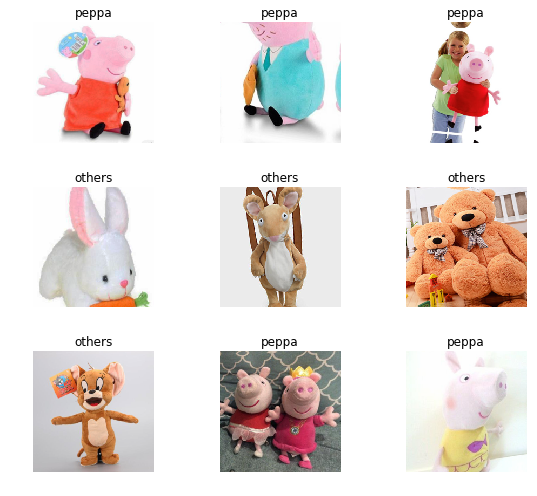

In [16]:
# viewing some of the images
data.show_batch(rows=3, figsize=(8,7))

In [17]:
# creating a resnet34
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 74696866.10it/s]


In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.885299,0.213989,0.065789
2,0.501106,0.055684,0.013158
3,0.363830,0.032314,0.013158
4,0.288097,0.028840,0.013158


In [19]:
# saving the weights so we don't have to retrain it each time
learn.save('stage-1')

In [20]:
learn.unfreeze()

## Learning rate

Finding and plotting the learning rate

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


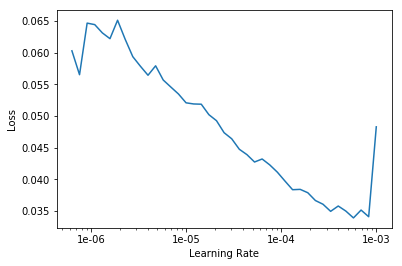

In [22]:
learn.recorder.plot()

**selecting a slice**

We select the slice with the maximum downward slope (which is not a bump)

In [23]:
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.062243,0.016471,0.000000


In [24]:
learn.save('stage-2')

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

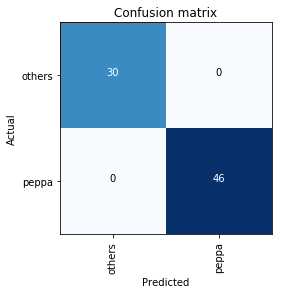

In [26]:
# we see that our model is 100% accurate
interp.plot_confusion_matrix()

## Cleaning up

Some of the losses / missclassifications might not be due to the performance of the model but because of the noise in the data. Hence, it is a good practice to clean the data. In this case, we have achieved 100% accurarcy but that won't be the case in every application. Uncomment the following 4 code cells to delete noisy images

In [33]:
# from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with <code>.from_toplosses</code> We then feed the top losses indexes and corresponding dataset to <code>ImageCleaner</code>.

Notice that the widget will not delete images directly from disk but it will create a new csv file <code>cleaned.csv</code> from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

Note: Please Set the Number of images to a number that you'd like to view: ex:  <code>n_imgs=100</code>

In [34]:
# ds, idxs = DatasetFormatter().from_toplosses(learn, n_imgs=100)

In [35]:
# ImageCleaner(ds, idxs, path)



Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. ImageCleaner will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from top_losses.ImageCleaner(ds, idxs)

You can also find duplicates in your dataset and delete them! To do this, you need to run .from_similars to get the potential duplicates' ids and then run ImageCleaner with duplicates=True. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.


In [36]:
# ds, idxs = DatasetFormatter().from_similars(learn)

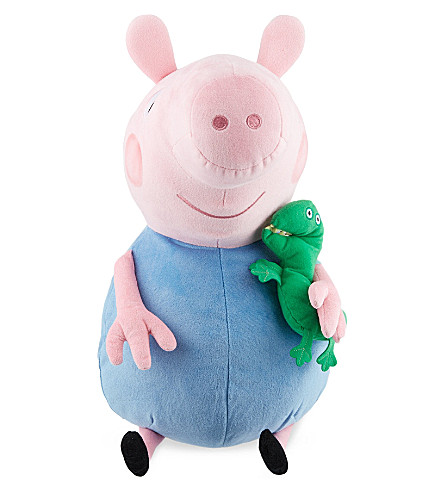

In [37]:
# opening a random image and making a prediction
img = open_image(path/'peppa/00000041.jpg')
img

In [39]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)

peppa
